Two Classes Horizontal Translation. 2 Dimensional data.
100 batches of 152 instances



METHOD: Static lp as classifier
Execution time:  0.37479990035060784
Average MCC:  0.10271154000670155
Average error: 45.92139999999999
Average macro-F1: 0.3956800331280773
Average micro-F1: 0.5365000000000001
Acurácia Média:  54.07860000000001
Desvio Padrão:  9.968750475360489
Variância:  99.37598603999997


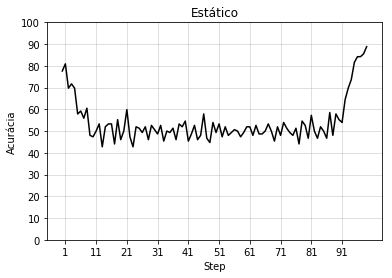

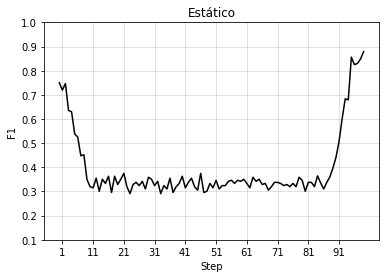




METHOD: Sliding lp as classifier
Execution time:  0.40708829390225953
Average MCC:  0.009740730726073184
Average error: 49.5925
Average macro-F1: 0.3379303580986835
Average micro-F1: 0.5010999999999999
Acurácia Média:  50.4075
Desvio Padrão:  4.861445746894641
Variância:  23.633654749999994


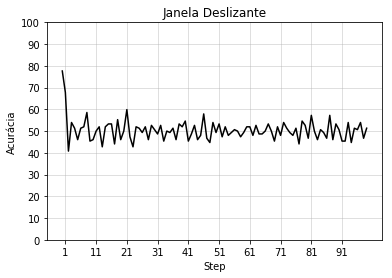

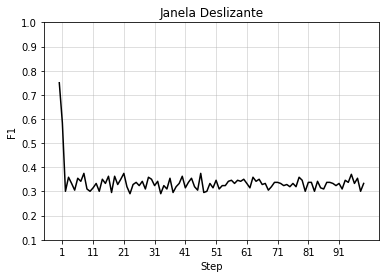




METHOD: Incremental lp as classifier
Execution time:  5.680257632866634
Average MCC:  0.08541122362694308
Average error: 46.65820000000001
Average macro-F1: 0.38438626108504104
Average micro-F1: 0.5288999999999998
Acurácia Média:  53.34179999999999
Desvio Padrão:  8.818879563754116
Variância:  77.77263676


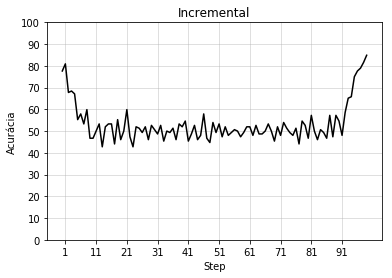

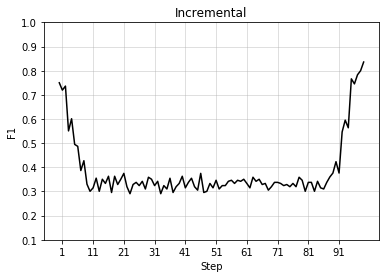




METHOD: lp as classifier and kde as core support extraction with cutting data method
Execution time:  0.54563329459116
Average MCC:  0.4948925876406713
Average error: 26.039699999999996
Average macro-F1: 0.683158233071949
Average micro-F1: 0.7445999999999999
Acurácia Média:  73.9603
Desvio Padrão:  18.156461078910723
Variância:  329.65707890999994


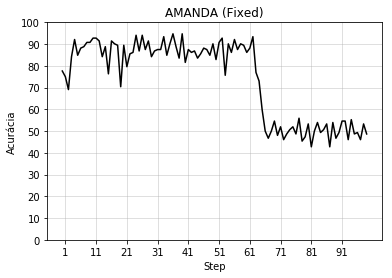

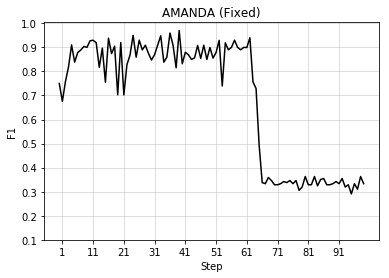




METHOD: lp as classifier and kde and Hellinger distance as dynamic CSE
AMANDA-DCP Hellinger | Mean keeping percentage=0.31 | Std keeping percentage=0.19
Execution time:  0.5627018296735606
Average MCC:  -0.10576060995139988
Average error: 54.58520000000001
Average macro-F1: 0.4319840818459135
Average micro-F1: 0.4512
Acurácia Média:  45.41479999999999
Desvio Padrão:  31.486025677433474
Variância:  991.3698129600001


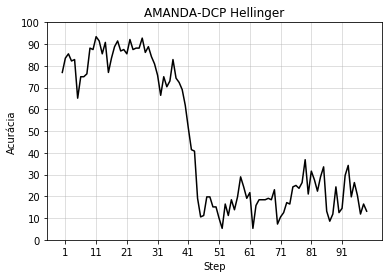

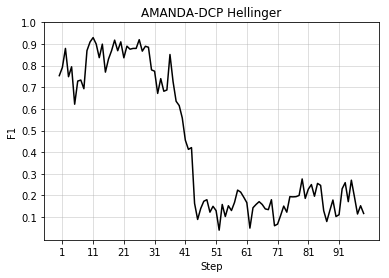




METHOD: lp as classifier and kde and Hellinger2 distance as dynamic CSE
AMANDA-DCP Hellinger2 | Mean keeping percentage=0.41 | Std keeping percentage=0.06
Execution time:  0.5297497288721686
Average MCC:  0.01755503280344207
Average error: 49.2175
Average macro-F1: 0.3436028345758039
Average micro-F1: 0.5048999999999999
Acurácia Média:  50.7825
Desvio Padrão:  5.434193477416865
Variância:  29.530458749999998


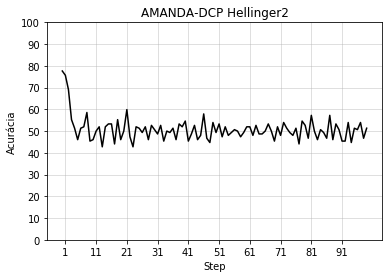

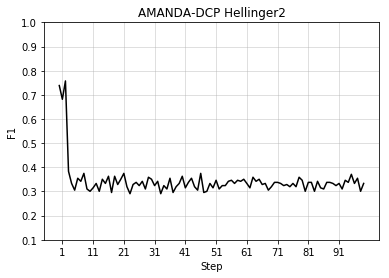




METHOD: lp as classifier and kde and BBD distance as dynamic CSE
AMANDA-DCP BBD - β = -1.000 | Mean keeping percentage=0.30 | Std keeping percentage=0.09
Execution time:  0.519311423944405
Average MCC:  0.03646923111788529
Average error: 48.20439999999999
Average macro-F1: 0.3575278981313447
Average micro-F1: 0.5143
Acurácia Média:  51.79560000000001
Desvio Padrão:  7.984335328629429
Variância:  63.749610640000014


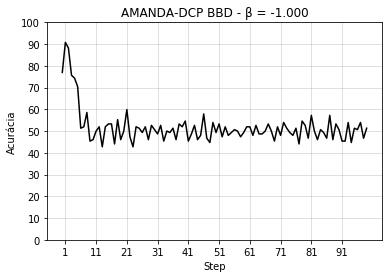

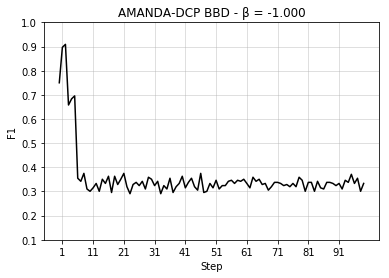

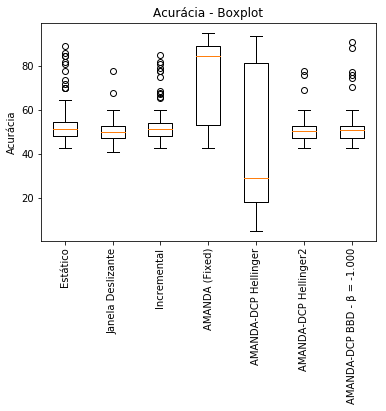

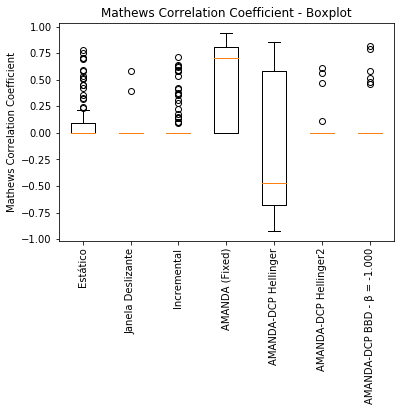

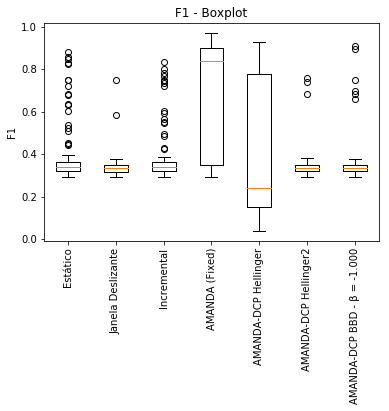

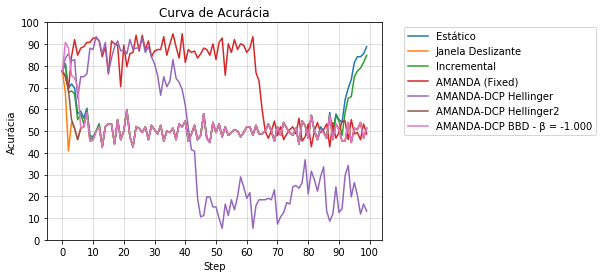

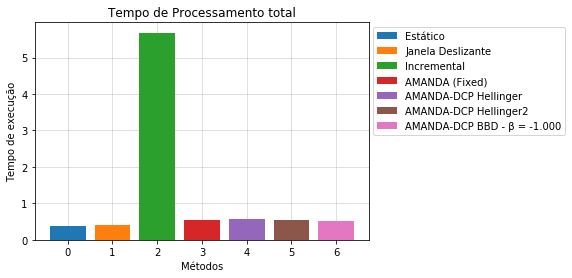

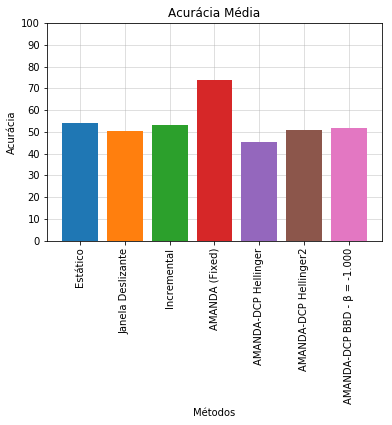

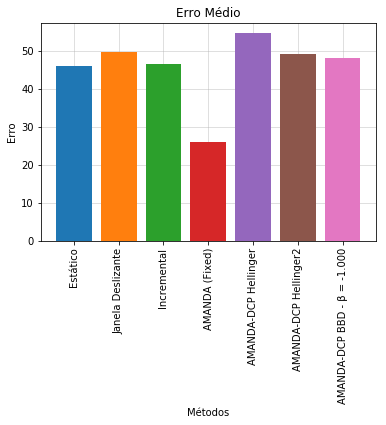

Pos 6 - Redução do Erro (Janela Deslizante):-6.788452363781623
Pos 3 - Redução do Erro (Incremental):-1.36246130632083
Pos 1 - Redução do Erro (AMANDA (Fixed)):36.764450263135494
Pos 7 - Redução do Erro (AMANDA-DCP Hellinger):-16.020754975165804
Pos 5 - Redução do Erro (AMANDA-DCP Hellinger2):-6.095017252665582
Pos 4 - Redução do Erro (AMANDA-DCP BBD - β = -1.000):-4.221632956474466


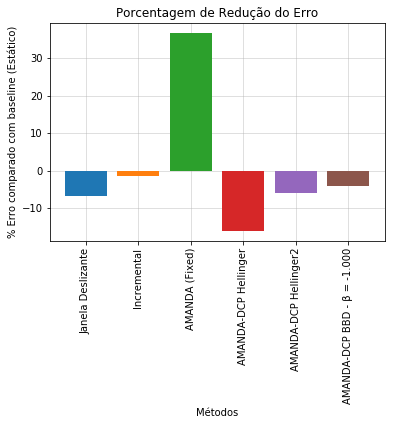

In [1]:
%matplotlib inline
import sys
import os
from pathlib import Path
os.chdir(Path(os.getcwd()).resolve().parents[4])

import setup
from methods import runExperiments
from methods import static_classifier
from methods import amanda_dynamic
from methods import amanda_fixed
from methods import incremental_LN
from methods import deslizante_LN
from methods import compose_gmm_version


class Experiment():
     def __init__(self, method, K=None, excludingPercentage=None, densityFunction=None, clfName=None, distanceMetric=None, beta=None):
        self.method = method
        self.clfName = clfName
        self.densityFunction=densityFunction
        self.excludingPercentage = excludingPercentage
        self.K_variation = K
        self.distanceMetric = distanceMetric
        self.beta = beta


def loadLevelResults(path, sep, key, steps):
    originalAccs, F1s, time = setup.loadLevelIwBoxplotResults(path, sep)
    predictions = F1s[key]
    predictions = [ predictions[i::steps] for i in range(steps) ]
    
    return predictions, originalAccs[key], time[key]


def main():
    experiments = {}
    is_windows = sys.platform.startswith('win')
    sep = '\\'

    if is_windows == False:
        sep = '/'

    path = os.getcwd()+sep+'data'+sep
    
    # SETTINGS
    sslClassifier = 'lp' # lp = label propagation, rf = random forests, cl = cluster and label, knn = k-nn, svm = svm
    steps = 100
    poolSize = None
    isBatchMode = True # False = Stream
    isBinaryClassification = True
    isImbalanced = False
    externalResults = []
    
    # Load dataset
    dataValues, dataLabels, description = setup.load2CHT(path, sep)
    
    # 5% of initial labeled data
    labeledData = int(0.05*len(dataLabels))

    # Static SSL
    experiments[0] = Experiment(static_classifier, 11, clfName=sslClassifier)
    
    # Sliding SSL
    experiments[1] = Experiment(deslizante_LN, 11, clfName=sslClassifier)
    
    # Incremental SSL
    experiments[2] = Experiment(incremental_LN, 11, clfName=sslClassifier)
    
    # Proposed Method 1 (AMANDA - Fixed core extraction percentage)
    experiments[3] = Experiment(amanda_fixed, 11, 0.75, "kde", sslClassifier)

    # Proposed method 2 (AMANDA - DCP Original)
    experiments[4] = Experiment(amanda_dynamic, 2, None, "kde", sslClassifier, 'Hellinger')
    
    # Proposed method 3 (AMANDA - DCP Hellinger2)
    experiments[5] = Experiment(amanda_dynamic, 9, None, "kde", sslClassifier, 'Hellinger2')                         
    
    # Proposed method 4 (AMANDA - DCP BBD)
    lastIndex = list(experiments.keys())[-1]
    betas = [-1]
    bestK = [6]
    for i in range(len(betas)):
        experiments[lastIndex+1+i] = Experiment(amanda_dynamic, bestK[i], None, "kde", sslClassifier, 'BBD', beta=betas[i])
    
    # Proposed method 5 (AMANDA - DCP HDDDM)
    #experiments[17] = Experiment(amanda_dynamic, 2, None, "kde", sslClassifier, 'HDDDM')
    
    
    # COMPOSE GMM (Python version)
    #experiments[5] = Experiment(compose_gmm_version, 2)
    
    # levelIw matlab results
    #predictionsLevelIw, originalAccsLevelIw, timeLevelIw = loadLevelResults(path, sep, '2CHT', steps)
    #externalResults.append({"name":"Level IW", "predictions":predictionsLevelIw, "accuracies":originalAccsLevelIw, "time":timeLevelIw})
    
    # Run experiments
    runExperiments.run(dataValues, dataLabels, description, isBinaryClassification, isImbalanced, 
                       experiments, steps, labeledData, isBatchMode, poolSize, externalResults)
    

if __name__ == "__main__":
    main()